In [1]:
import tushare
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from single_stock_pi import SingleStockPI

In [2]:
pro = tushare.pro_api()
ts_code_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code')['ts_code'][:100]
def download_data(ts_code_list):
    for ts_code in ts_code_list:
        start_date = '20100101'
        end_date = '20200101'
        df = tushare.pro_bar(ts_code=ts_code, adj='qfq', start_date=start_date, end_date=end_date)
        df.to_csv('./data/' + ts_code, mode = 'w')
    print("done")
    
def load_data(ts_code):
    filepath = './data/' + ts_code
    df = pd.read_csv(filepath)
    return df

In [3]:
# load data and reverse the time series
df = load_data('000036.SZ')
df = df.set_index(df.index[::-1]).sort_index()
df_train = df[df['trade_date'] <= 20180000]
df_test = df[df['trade_date'] > 20180000]

In [4]:
df_train.head()

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,2377,000036.SZ,20100104,4.1635,4.2775,4.1381,4.2268,4.1445,0.0823,1.9858,153902.60,102814.2410
1,2376,000036.SZ,20100105,4.2205,4.2585,4.0874,4.1888,4.2268,-0.0380,-0.8990,141040.99,92587.9307
2,2375,000036.SZ,20100106,4.1761,4.2205,4.1254,4.1381,4.1888,-0.0507,-1.2104,113644.51,74615.3410
3,2374,000036.SZ,20100107,4.1128,4.1445,3.9290,3.9543,4.1381,-0.1838,-4.4417,177149.70,112659.9735
4,2373,000036.SZ,20100108,3.9924,4.1001,3.9924,4.0494,3.9543,0.0951,2.4050,102364.93,65293.6218


In [5]:
df_test.head()

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
1891,486,000036.SZ,20180102,5.8827,6.1507,5.8827,6.0853,5.9088,0.1765,2.9871,199186.9,184953.106
1892,485,000036.SZ,20180103,6.1180,6.1180,6.0069,6.0330,6.0853,-0.0523,-0.8594,169622.5,156757.919
1893,484,000036.SZ,20180104,6.0395,6.0526,5.9611,6.0134,6.0330,-0.0196,-0.3249,120590.4,110635.195
1894,483,000036.SZ,20180105,6.0134,6.6147,6.0134,6.4905,6.0134,0.4771,7.9339,861750.3,853205.815
1895,482,000036.SZ,20180108,6.5363,6.8893,6.4709,6.6213,6.4905,0.1308,2.0153,861461.9,877342.882


In [6]:
close_price_train = df_train['close'].to_numpy()
log_returns_train = np.log(close_price_train[1:] / close_price_train[:-1])
close_price_test = df_test['close'].to_numpy()
log_returns_test = np.log(close_price_test[1:] / close_price_test[:-1])

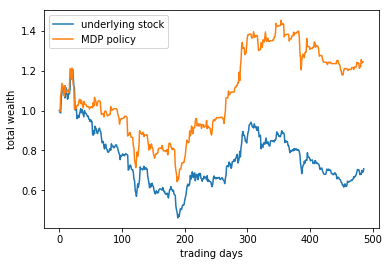

In [7]:
PI_model = SingleStockPI(alphas = [0.25,0.5,0.75], log_returns = log_returns_train)
PI_model.gamma = 0.95
PI_model.friction = 1e-4
_, policy = PI_model.policy_iteration()

policy_log_returns = PI_model.policy_test(policy, log_returns_test)
policy_wealth = np.exp(np.cumsum(policy_log_returns))
plt.plot(close_price_test/close_price_test[0])
plt.plot(policy_wealth)
plt.xlabel('trading days')
plt.ylabel('total wealth')
plt.legend(['underlying stock','MDP policy'])
#plt.show()
plt.savefig('returns.png')

In [8]:
def MDP_policy_single_stock_test(ts_code, gamma = 0.95, friction = 1e-4):
    # load data and reverse the time series
    df = load_data(ts_code)
    df = df.set_index(df.index[::-1]).sort_index()
    df_train = df[df['trade_date'] <= 20180000]
    df_test = df[df['trade_date'] > 20180000]
    
    close_price_train = df_train['close'].to_numpy()
    log_returns_train = np.log(close_price_train[1:] / close_price_train[:-1])
    close_price_test = df_test['close'].to_numpy()
    log_returns_test = np.log(close_price_test[1:] / close_price_test[:-1])
    
    PI_model = SingleStockPI(alphas = [0.25,0.5,0.75], log_returns = log_returns_train)
    PI_model.gamma = gamma
    PI_model.friction = friction
    _, policy = PI_model.policy_iteration()

    policy_log_returns = PI_model.policy_test(policy, log_returns_test)
    policy_wealth = np.exp(np.cumsum(policy_log_returns))
    plt.plot(close_price_test/close_price_test[0])
    plt.plot(policy_wealth)
    plt.xlabel('trading days')
    plt.ylabel('total wealth')
    plt.legend(['underlying stock','MDP policy'])
    plt.title(ts_code)
    plt.show()
    
    normalized_stock_wealth = close_price_test[-1]/close_price_test[0]
    normalized_policy_wealth = policy_wealth[-1]/policy_wealth[0]
    return normalized_stock_wealth, normalized_policy_wealth

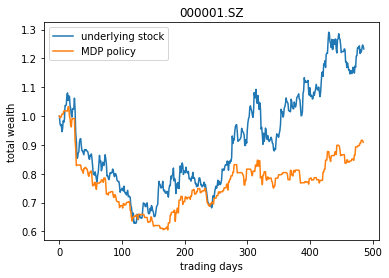

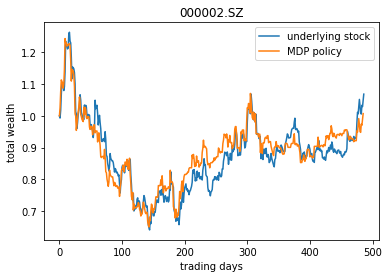

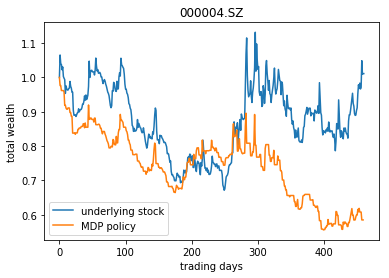

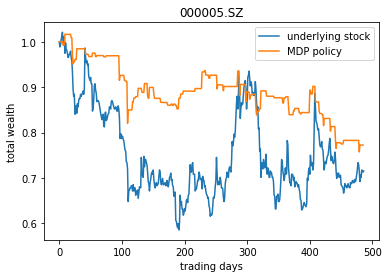

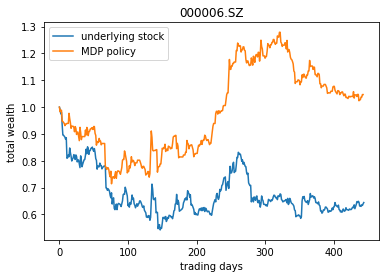

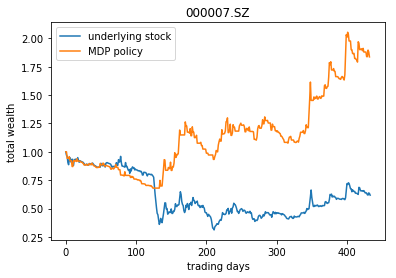

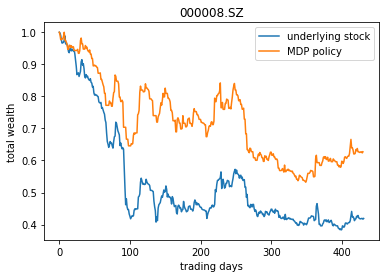

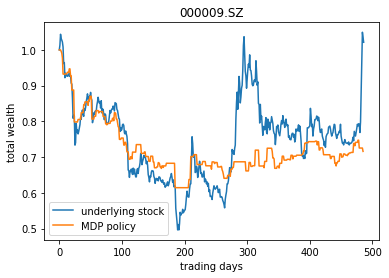

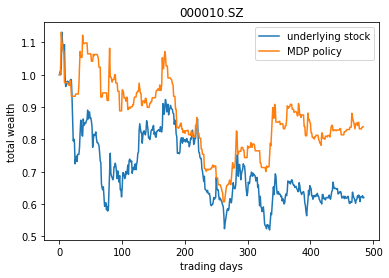

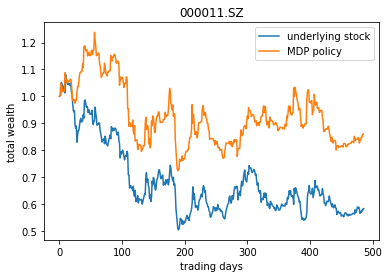

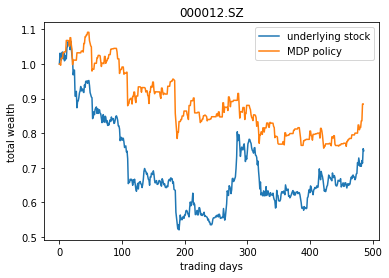

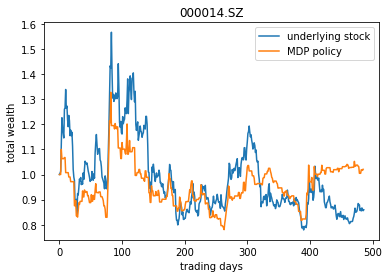

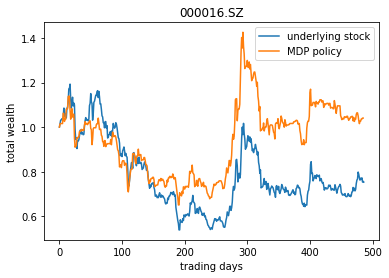

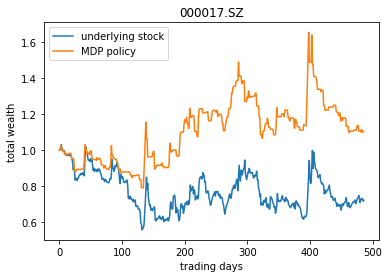

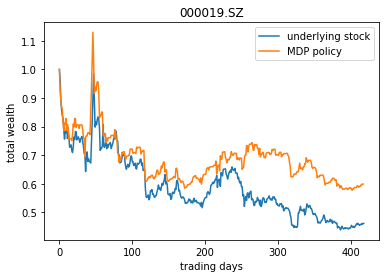

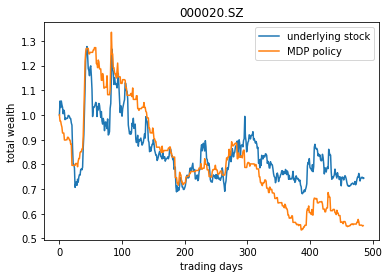

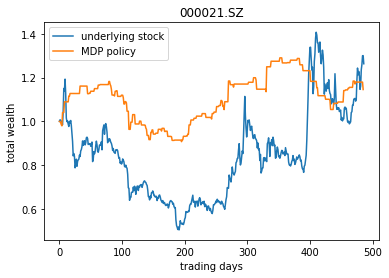

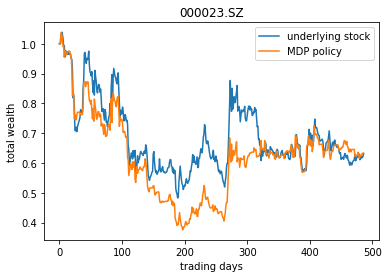

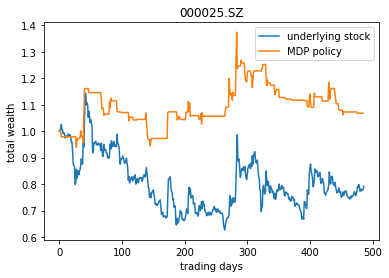

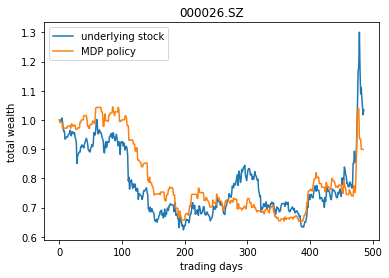

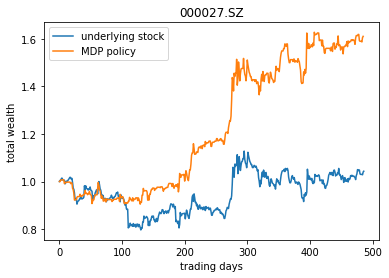

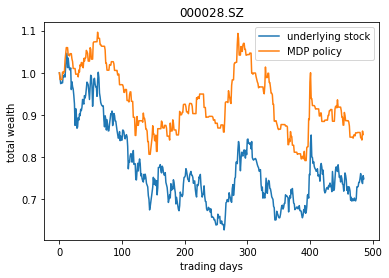

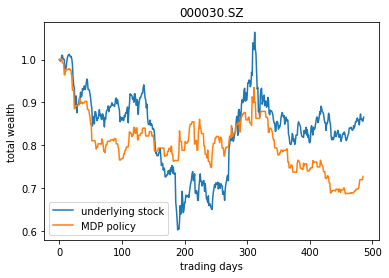

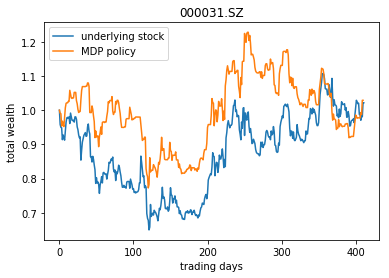

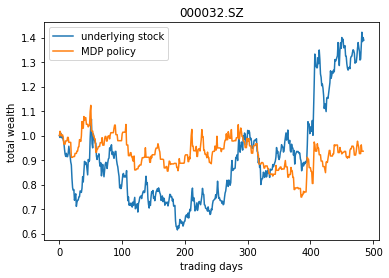

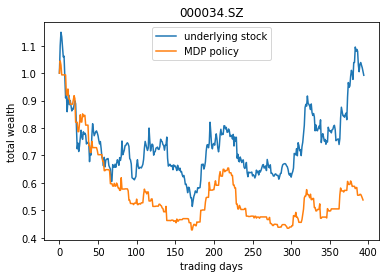

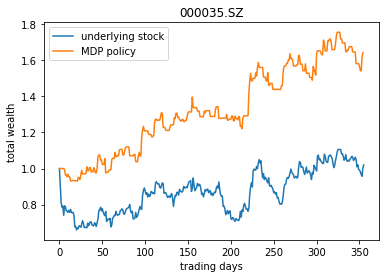

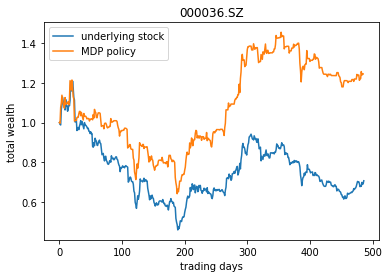

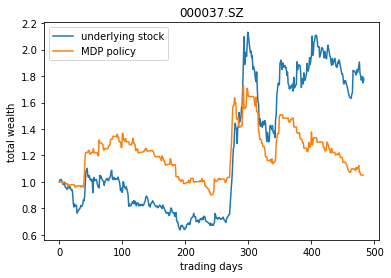

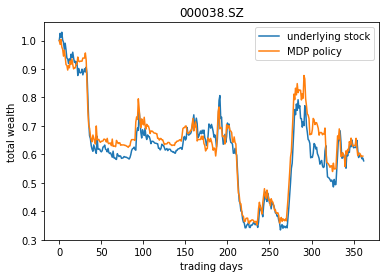

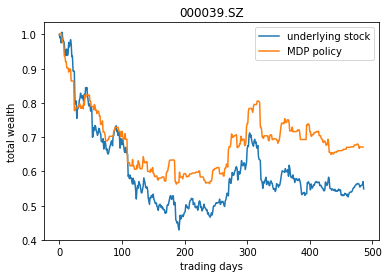

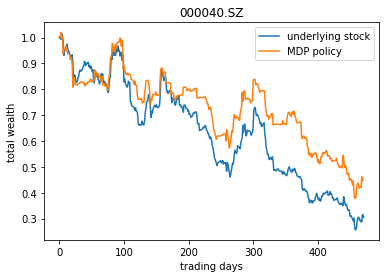

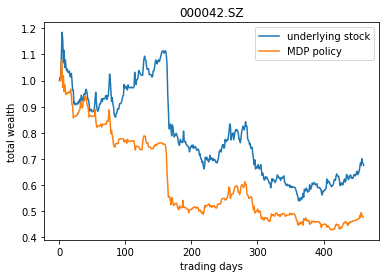

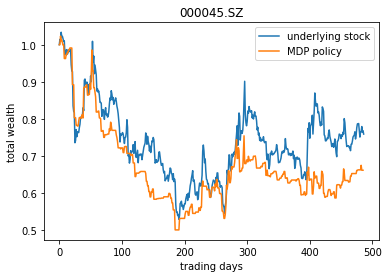

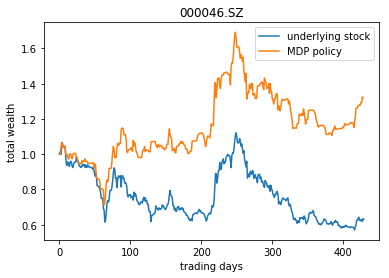

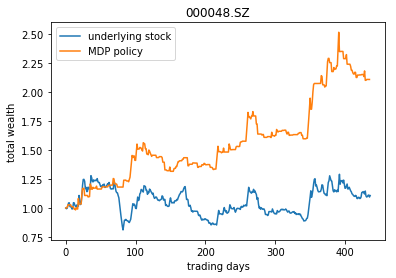

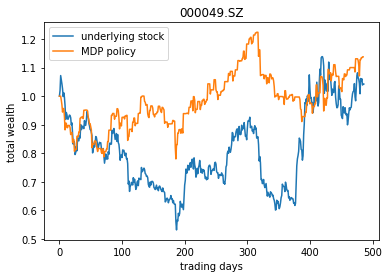

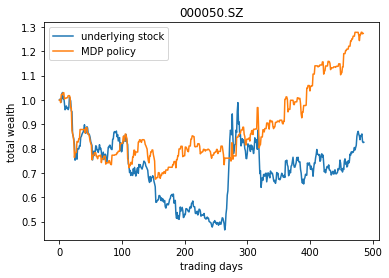

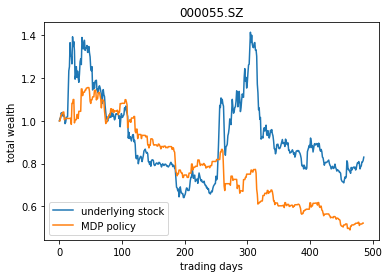

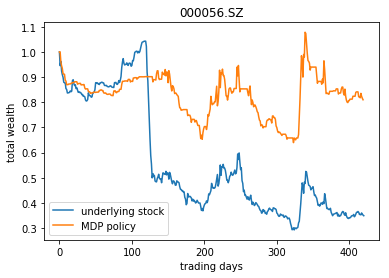

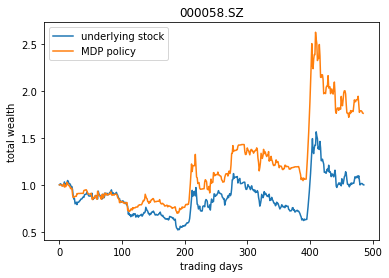

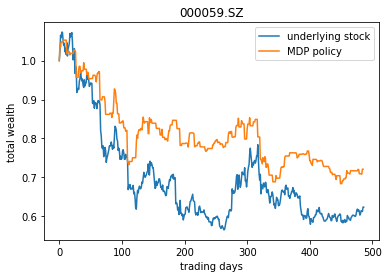

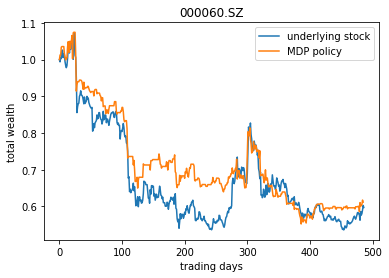

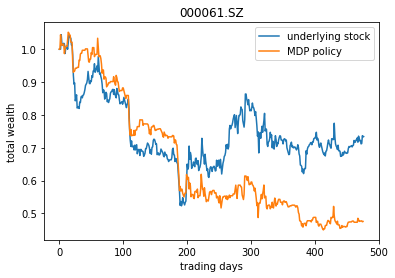

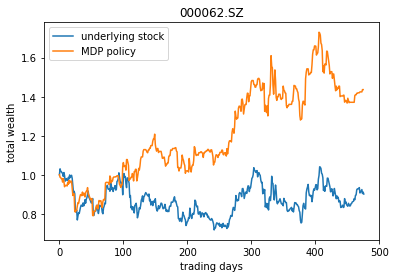

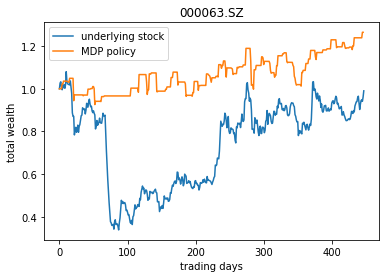

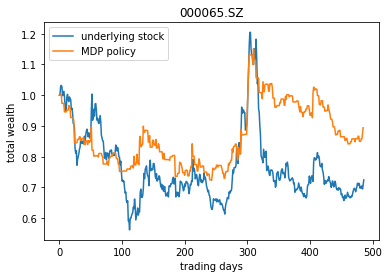

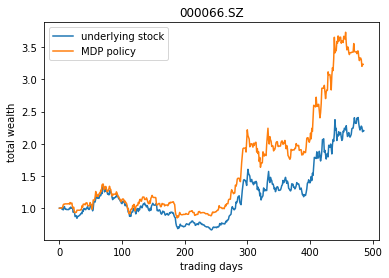

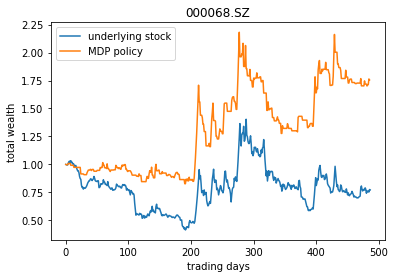

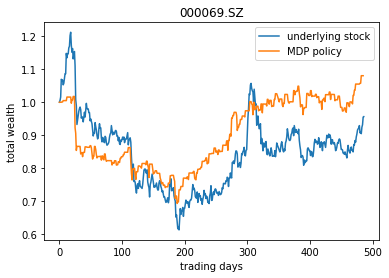

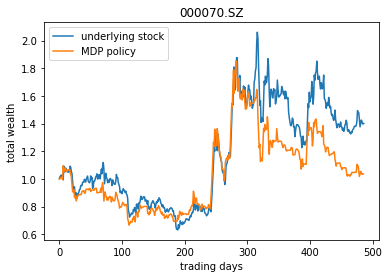

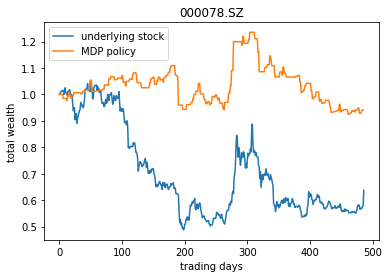

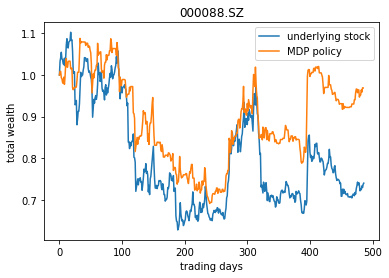

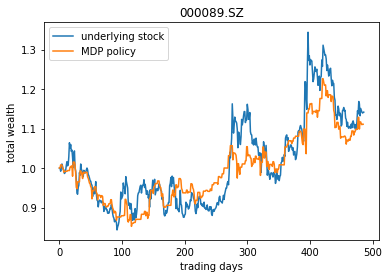

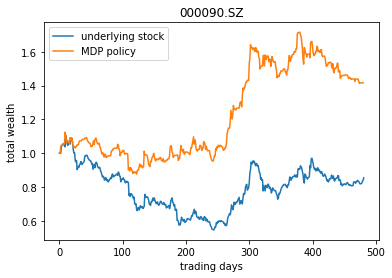

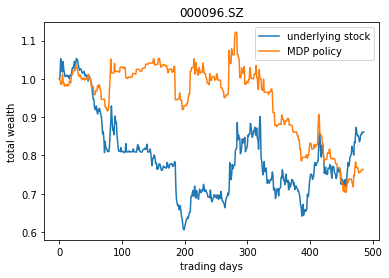

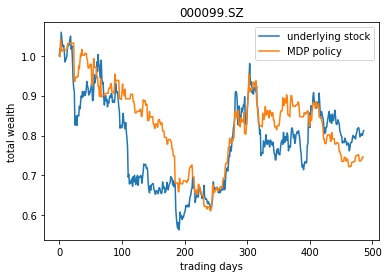

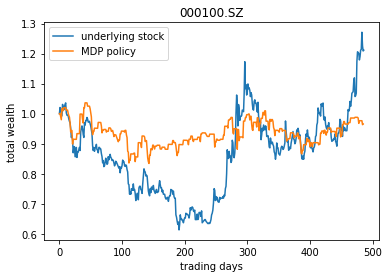

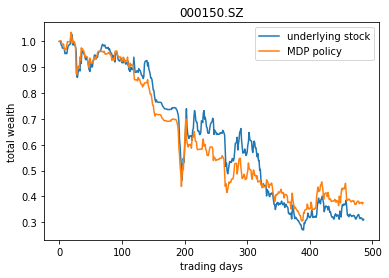

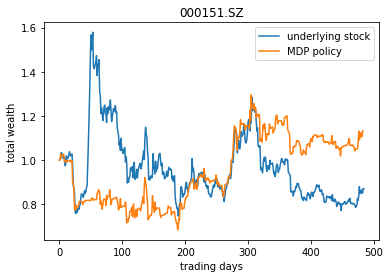

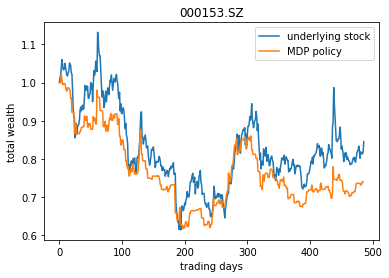

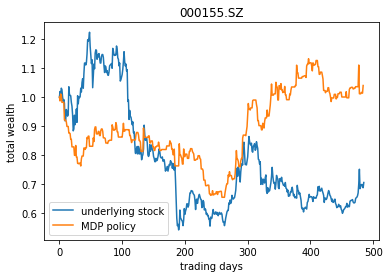

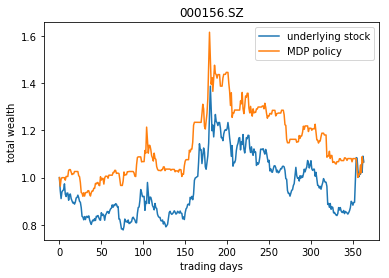

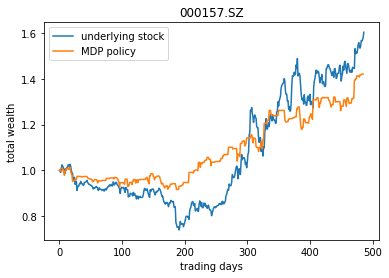

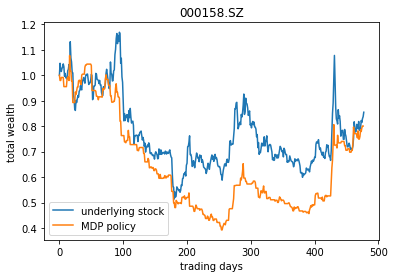

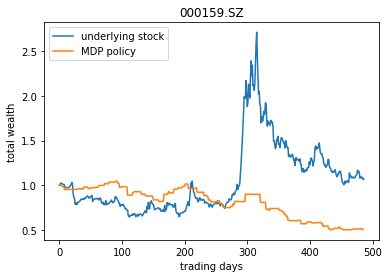

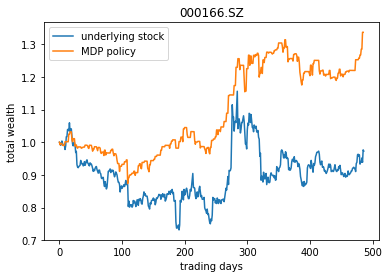

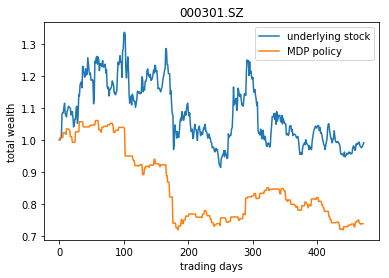

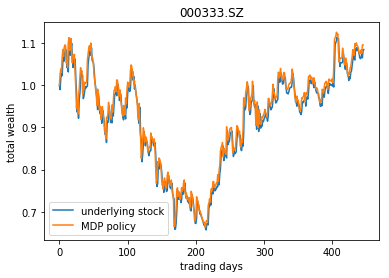

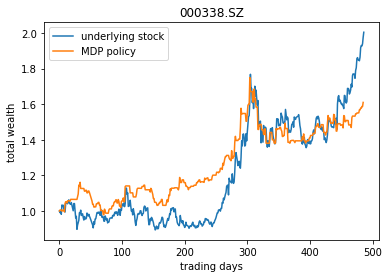

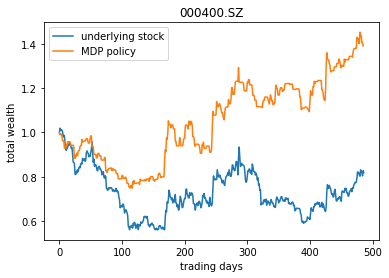

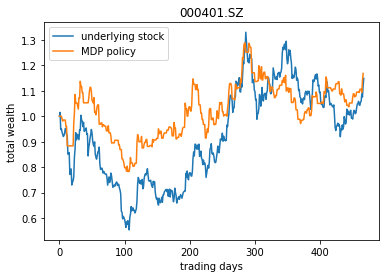

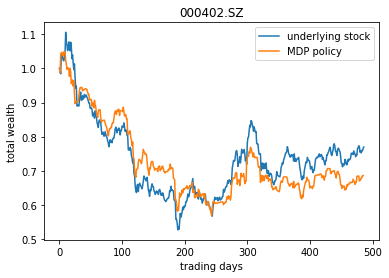

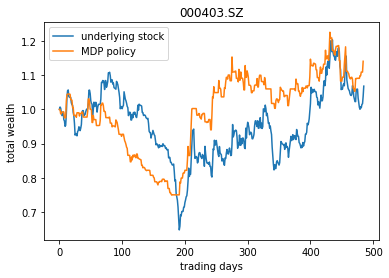

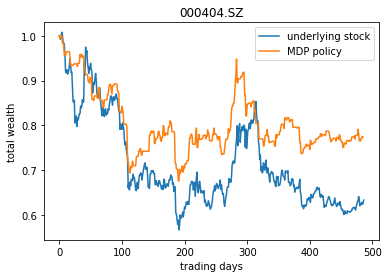

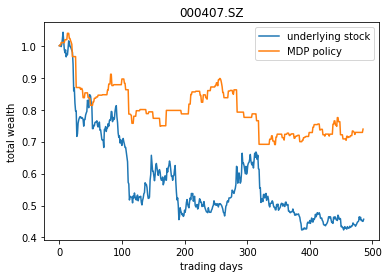

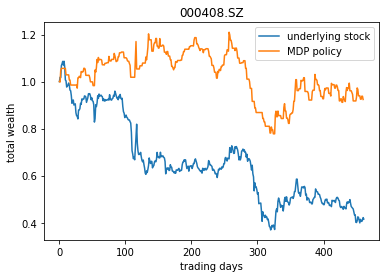

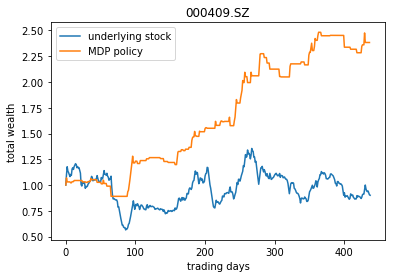

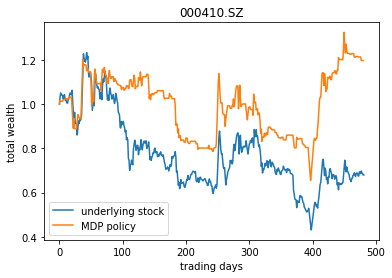

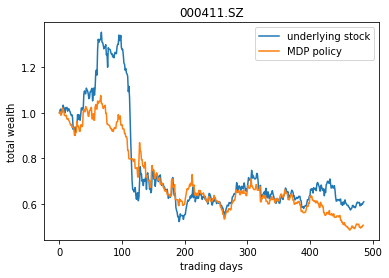

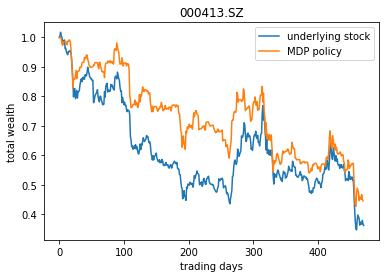

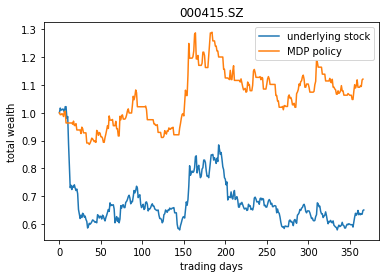

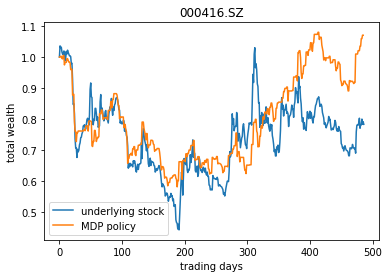

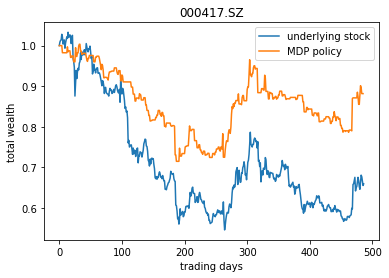

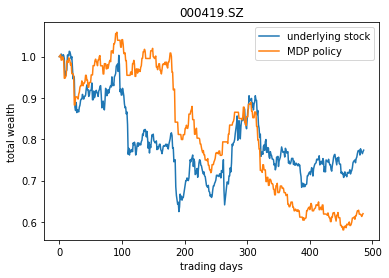

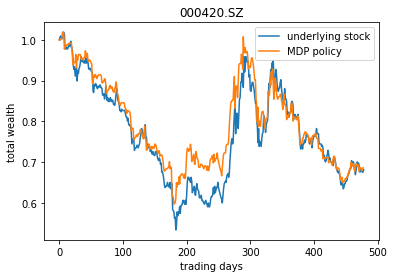

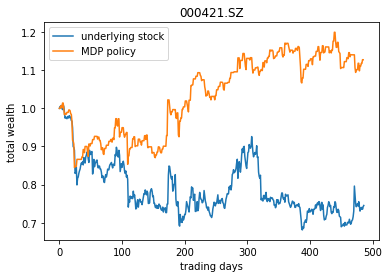

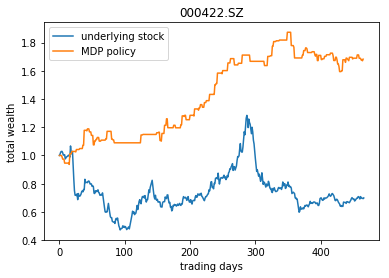

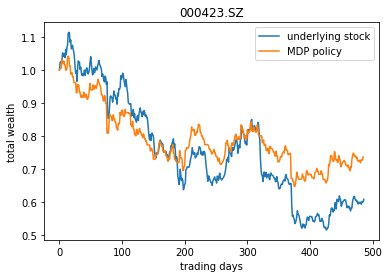

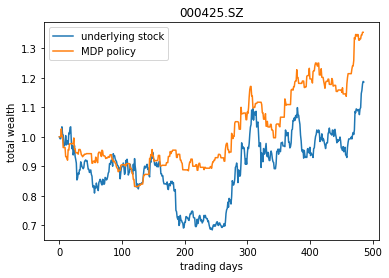

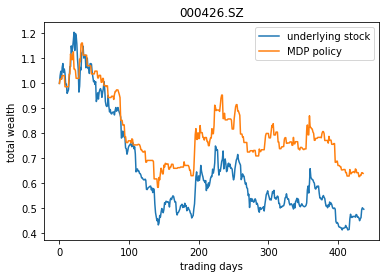

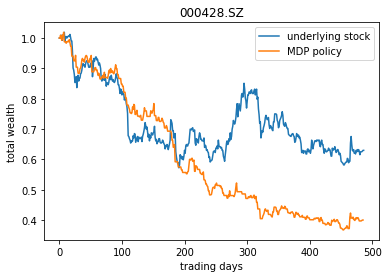

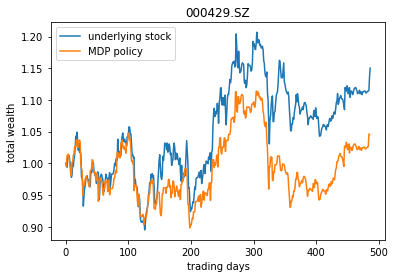

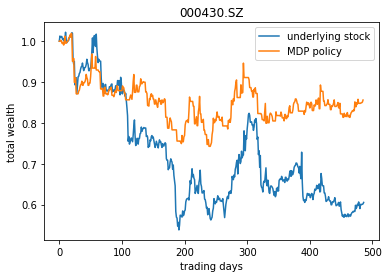

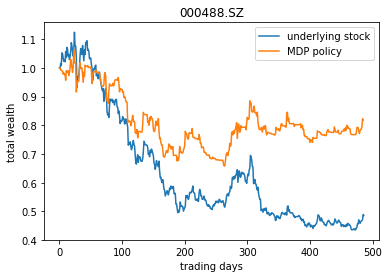

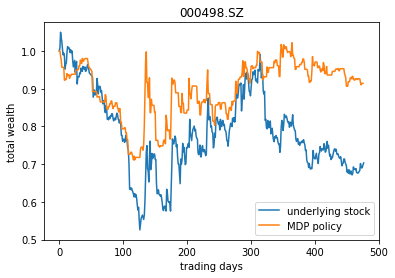

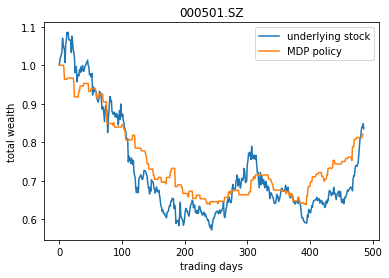

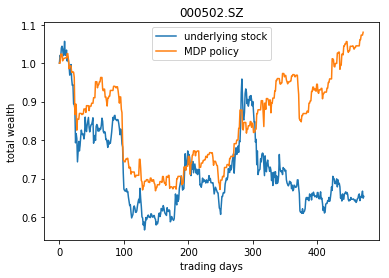

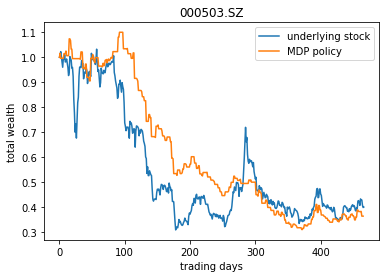

In [9]:
stock_wealth_list = []
policy_wealth_list = []
for ts_code in ts_code_list:
    if ts_code == '000029.SZ':
        # 停牌
        continue
    stock_wealth, policy_wealth = MDP_policy_single_stock_test(ts_code)
    stock_wealth_list.append(stock_wealth)
    policy_wealth_list.append(policy_wealth)
stock_wealth_list = np.array(stock_wealth_list)
policy_wealth_list = np.array(policy_wealth_list)

In [10]:
print("Mean excess return = {}".format(np.mean(policy_wealth_list-stock_wealth_list)))
print("Nums of positive excess return = {}".format(np.sum(policy_wealth_list>stock_wealth_list)))

Mean excess return = 0.1524957005150884
Nums of positive excess return = 65


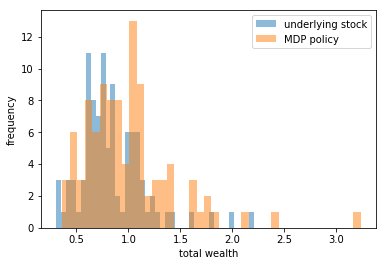

In [11]:
plt.hist(stock_wealth_list,bins = 40, alpha = 0.5)
plt.hist(policy_wealth_list,bins = 40, alpha = 0.5)
plt.xlabel('total wealth')
plt.ylabel('frequency')
plt.legend(['underlying stock','MDP policy'])
#plt.show()
plt.savefig('hist.png')